In [1]:
from PertDist.pert import PERT
import seaborn as sns
import pandas as pd
import math

pd.options.display.float_format = '{:,}'.format

# Estimated values are all in this 1st section

In [2]:
VALUATION_MULTIPLE = [7, 10, 15]

In [3]:
IMPORTANT_TERMS = {
    'avg_lead_value': [3, 6, 8], # % of the total premium
    'lead_value_for_quotes': [.3, .5, .6],  # % of the value of leads from financed accounts
    'percent_of_quotes_with_dec_pages': [.15, .25, .50],
    'lead_value_growth_factor': [.05, .05, .05],
    'quotes_per_account': [2, 4, 6],
    'average_unit_size': [12000, 15000, 20000],
    'cof_under_prime': [0, 1, 2],
    'avg_apr_over_prime': [.5, 1.5, 2.5],
    'monthly_fee_income': [.00040, .00057, .00060],
    'write_offs': [.001, .002, .003]
}

CONSTANTS = {
    'service_base_salary': 45000,
    'sales_base_salary': 60000,
    'programmer_base_salary': 100000,
    'number_of_management': 3
}

MONTHS_ESTIMATED = 60
PRIME_RATE = 3.25  # as of April 2020
MONTHS_BEFORE_SALES_BEGIN = [3, 4, 6]

In [4]:
def calculate_early_vals(df):
    # Values that are vaguely independent of volume
    df['number_of_programmers'] = [math.floor(val/12) for val in range(MONTHS_ESTIMATED)]
    df['general_expenses'] = [1000 + 1000 * math.floor(val/12) for val in range(MONTHS_ESTIMATED)]
    df['server_expenses'] = [300 + 100 * val for val in range(MONTHS_ESTIMATED)]
    df['software_expenses'] = df['server_expenses'] * 1.5
    df['professional_expenses'] = [1000 + 1000 * math.floor(val/12) for val in range(MONTHS_ESTIMATED)]
    df['management_salary'] = [100000 for _ in range(23)] + [150000 for _ in range(MONTHS_ESTIMATED - 23)]
    df['marketing_expenses'] = [0, 0, 0] + [2500 for _ in range(12)] + [5000 for _ in range(60 - 12 - 3)]

In [5]:
google_ads = {
    'pf_specific': {
        'max_searches': [20000, 21344, 23000],
        'click_through_rate': [.025, .0291, .030],
        'conversion_ratio': [.03, .0513, .08],
        'cost_per_click': [2, 2.87, 3.5],
        'growth_factor': .5,        # PF-specific terms will be the easiest to get high Google relevance with
        'additional_delay_in_months': 0,
        'web_traffic_representing_potential_customers': [0.35, 0.5, 0.65]
    },
    'insurance_agency__cheap': { # cheap is based on whether the name includes the word insurance or not
        'max_searches': [100000, 174055, 250000],
        'click_through_rate': [.025, .0291, .03],
        'conversion_ratio': [.03, .0513, .08],
        'cost_per_click': [2, 3, 4],
        'growth_factor': .25,
        'additional_delay_in_months': 0,
        'web_traffic_representing_potential_customers': [.1, .15, .2]
    },
    'insurance_agency__expensive': {
        'max_searches': [100000, 174055, 250000],
        'click_through_rate': [.025, .0291, .03],
        'conversion_ratio': [.03, .0513, .08],
        'cost_per_click': [10, 13, 15],
        'growth_factor': .25,
        'additional_delay_in_months': 0,
        'web_traffic_representing_potential_customers': [.1, .15, .2]}}


other_online_ads = {
    # Google makes up 88% of web searches, so these max_searches are set to 88% of the top values
    'pf_specific': {
        'additional_delay_in_months': 4
    },
    'insurance_agency__cheap': {
        'additional_delay_in_months': 4
    },
    'insurance_agency__expensive': {
        'additional_delay_in_months': 4}}

In [6]:
linkedin = {
    'cost': 65,
    'accounts_per_month_at_maturity': [45, 55.5, 70],
    'growth_factor': .15,
    'additional_delay_in_months': 1
}

In [7]:
trade_associations = {
    'avg_accounts_per_month_per_association': [3, 5, 8],
    'fee_per_account': [30, 100, 150],
    'additional_delay_in_months': 0
}

In [8]:
data_informed_cold_calls = {
    'cost_per_hour': [30, 33, 35],
    'sales_per_hour': [.5, .75, 1.5],
    'additional_delay_in_months': 1
}

# Functions

In [9]:
def return_pert_distribution(vals):
    # They can't all be equal, and they need to be in the proper order (low -> high)
    vals.sort()
    if vals[0] == vals[2]:
        vals[2] += .0000001
    return PERT(vals[0], vals[1], vals[2])

In [10]:
def growth_factor_calculation(max_value, cycles, growth_factor, resize=False):
    # Google makes up 88% of search results. 'resize' gives results for that remaining 12%.
    if resize:
        resize_factor = .12 / .88
        adjusted_max = max_value * resize_factor
        returned_list = [growth_factor * adjusted_max]
        for _ in range(cycles - 1):
            returned_list += [returned_list[-1] + (adjusted_max - returned_list[-1]) * growth_factor]
    else:
        returned_list = [growth_factor * max_value]
        for _ in range(cycles - 1):
            returned_list += [returned_list[-1] + (max_value - returned_list[-1]) * growth_factor]

    return returned_list

In [11]:
def linkedin_growth_factor_calculation(max_value, cycles, growth_factor):
    returned_list = [growth_factor * max_value]
    for _ in range(cycles - 1):
        returned_list += [returned_list[-1] + (max_value - returned_list[-1]) * growth_factor]
    return returned_list

In [12]:
def google_ad_growth(df, google_ads, other_online_ads):
    # Make an array for each variable
    for key in google_ads:
        max_search_val = return_pert_distribution(google_ads[key]['max_searches']).rvs(1)[0] \
            * return_pert_distribution(google_ads[key]['web_traffic_representing_potential_customers']).rvs(1)[0]
        ctr_val = return_pert_distribution(google_ads[key]['click_through_rate']).rvs(1)[0]
        conversion_val = return_pert_distribution(google_ads[key]['conversion_ratio']).rvs(1)[0]
        cpc_val = return_pert_distribution(google_ads[key]['cost_per_click']).rvs(1)[0]

        segment1 = [0 for month in range(months_before_sales)] \
            + [0 for month in range(google_ads[key]['additional_delay_in_months'])]
        segment2_len = MONTHS_ESTIMATED - len(segment1)

        generated1 = key + '_accounts_generated_google'
        accounts_generated = segment1 + growth_factor_calculation(
            max_search_val, segment2_len, google_ads[key]['growth_factor'])

        df[generated1] = [val * ctr_val * conversion_val for val in accounts_generated]
        
        quotes_gen1 = key + "_quotes_generated_google"
        df[quotes_gen1] = df[generated1] * quotes_per_account

        # Non-Google ads: same as Google ads, but max_searches are calculated as (google / .88) * .12
        segment1 = [0 for month in range(months_before_sales)] \
            + [0 for month in range(other_online_ads[key]['additional_delay_in_months'])]
        segment2_len = MONTHS_ESTIMATED - len(segment1)

        generated2 = key + '_accounts_generated_bing'
        accounts_generated2 = segment1 + growth_factor_calculation(
            max_search_val, segment2_len, google_ads[key]['growth_factor'], resize=True)
        df[generated2] = [val * ctr_val * conversion_val for val in accounts_generated2]
        
        quotes_gen2 = key + "_quotes_generated_bing"
        df[quotes_gen2] = df[generated2] * quotes_per_account
        
        # Adding costs
        cost_key1 = key + "_cost_google"
        cost_key2 = key + "_cost_bing"
        df[cost_key1] = df[generated1] * cpc_val / ctr_val
        df[cost_key2] = df[generated2] * cpc_val / ctr_val

In [13]:
def linkedin_projections(linkedin):
    total_delay1 = linkedin['additional_delay_in_months'] + months_before_sales
    linkedin_accounts_per_month = [0 for _ in range(total_delay1)] \
        + [1 + math.floor(val/6) for val in range(MONTHS_ESTIMATED - total_delay1)]
    df['linkedin_cost'] = [linkedin['cost'] * val for val in linkedin_accounts_per_month]

    mature_expectations = return_pert_distribution(linkedin['accounts_per_month_at_maturity']).rvs(1)[0]

    linkedin_accounts_generated = [0]
    for index in range(MONTHS_ESTIMATED):
        linkedin_accounts_generated += [linkedin_accounts_generated[-1]\
            + (linkedin_accounts_per_month[index] * mature_expectations - linkedin_accounts_generated[-1]) \
            * linkedin['growth_factor']]

    df['linkedin_accounts'] = linkedin_accounts_generated[1:]
    df['linkedin_quotes'] = df['linkedin_accounts'] * quotes_per_account

In [14]:
def trade_association_projections(trade_associations):
    total_delay2 = trade_associations['additional_delay_in_months'] + months_before_sales
    trade_deals = [0 for _ in range(total_delay2)] + [val +1 for val in range(MONTHS_ESTIMATED - total_delay2)]

    account_guess = return_pert_distribution(trade_associations['avg_accounts_per_month_per_association']).rvs(1)[0]
    df['trade_association_accounts'] = [trade_deals[inx] * account_guess for inx in range(MONTHS_ESTIMATED)]
    df['trade_association_quotes'] = df['trade_association_accounts'] * quotes_per_account

    df['trade_association_costs'] = df['trade_association_accounts'] \
        * return_pert_distribution(trade_associations['fee_per_account']).rvs(1)[0]

In [15]:
def cold_calls(cc_data):
    total_delay3 = cc_data['additional_delay_in_months'] + months_before_sales
    hours_spent_calling = [0 for _ in range(total_delay3)] + [20, 30, 40] + [160 + 120 * math.floor(val/6) for val in range(
        MONTHS_ESTIMATED - total_delay3 - 3)]

    salesperson_cost_per_hour = CONSTANTS['sales_base_salary'] * 1.3 / (50 * 40)
    sales_per_hour = return_pert_distribution(cc_data['sales_per_hour']).rvs(1)[0]

    df['cold_calls_cost'] = [salesperson_cost_per_hour * hour for hour in hours_spent_calling]
    df['cold_calls_accounts'] = [sales_per_hour * hour for hour in hours_spent_calling]
    df['cold_calls_quotes'] = df['cold_calls_accounts'] * quotes_per_account
    df['number_of_salespeople'] = [hours // 120 for hours in hours_spent_calling]

In [16]:
def adding_stuff_together(df):
    df['monthly_new_loans'] = df['pf_specific_accounts_generated_google'] + df['pf_specific_accounts_generated_bing']\
        + df['insurance_agency__cheap_accounts_generated_google'] + df['insurance_agency__cheap_accounts_generated_bing']\
        + df['insurance_agency__expensive_accounts_generated_google'] + df['insurance_agency__expensive_accounts_generated_bing']\
        + df['linkedin_accounts'] + df['cold_calls_accounts'] + df['trade_association_accounts']

    df['monthly_new_quotes'] = df['pf_specific_quotes_generated_google'] + df['pf_specific_quotes_generated_bing']\
        + df['insurance_agency__cheap_quotes_generated_google'] + df['insurance_agency__cheap_quotes_generated_bing']\
        + df['insurance_agency__expensive_quotes_generated_google'] + df['insurance_agency__expensive_quotes_generated_bing']\
        + df['linkedin_quotes'] + df['trade_association_quotes'] + df['cold_calls_quotes']    

In [17]:
def calculate_active_units(df):
    df['monthly_amount_financed'] = df['monthly_new_loans'] * avg_unit_size

    m_new_loans = df['monthly_new_loans'].tolist()
    # Give the last 10 months + 1/2 the 11th
    new_list = []
    for index in range(len(m_new_loans)):
        if index <= 10:
            new_list += [sum(m_new_loans[:index + 1])]
        else:
            new_list += [sum(m_new_loans[index - 10: index + 1]) + m_new_loans[index-11] / 2]

    df['active_units'] = new_list

In [18]:
def calculate_ar(df):
    # Calculating our AR is hard. Our loans will average durations of ~10.5 months with 9 (or 10) payments.
    # I'm doing a simplified interest calculation as an approximation.
    m_amt_fin = df['monthly_amount_financed'].tolist()

    new_list = []
    for index in range(len(m_amt_fin)):
        monthly_ar = m_amt_fin[index]  # This month's AF counts in full towards AR
        if index > 0:
            for ndx in range(index):
                # For every prior month, assign half it's weight as X/9 and the other
                # half as (X-1)/9. 9/9 & 8/9, 8/9 & 7/9, etc.
                months_af = m_amt_fin[index - ndx - 1]
                monthly_ar += max(months_af * ((9 - ndx) / 9) / 2, 0)
                monthly_ar += max(months_af * ((9 - ndx - 1) / 9) / 2, 0)

        new_list += [round(monthly_ar, 0)]

    df['monthly_accounts_receivable'] = new_list
    df['monthly_outstanding_principal'] = df['monthly_accounts_receivable'] * .98  # This is a reasonable approximation.

In [19]:
def calculate_lead_value(df):
    # Our leads require work to get to their full value. Features to make insureds more likely to convert to a new agency,
    # developing a network to sell leads to, software to support that network, etc.
    # I'm assuming it's easy to get some value as soon as we're ready to start selling leads,
    # but the growth process will be slow to achieve their full value.

    months_before_working_on_lead_value = 9
    final_account_lead_value = return_pert_distribution(IMPORTANT_TERMS['avg_lead_value']).rvs(1)[0]
    lead_value_growth_factor = return_pert_distribution(IMPORTANT_TERMS['lead_value_growth_factor']).rvs(1)[0]
    quote_to_acct_value_ratio = return_pert_distribution(IMPORTANT_TERMS['lead_value_for_quotes']).rvs(1)[0]

    returned_list = [final_account_lead_value / 2]
    for _ in range(MONTHS_ESTIMATED - months_before_working_on_lead_value - 1):
        returned_list += [returned_list[-1] + (
            final_account_lead_value - returned_list[-1]) * lead_value_growth_factor]

    df['account_lead_value'] = [0 for _ in range(months_before_working_on_lead_value)] + returned_list
    df['quote_lead_value'] = df['account_lead_value'] * quote_to_acct_value_ratio



    # In calculating our income from selling data, I'm assuming a 9 month delay from quote/account to a sale.
    # I'm also assuming an average down payment of 15% (85% financed)
    monthly_quotes = df['monthly_new_quotes'].tolist()
    monthly_accounts = df['monthly_new_loans'].tolist()
    avg_financed_portion = .85
    quote_total_premium = avg_unit_size / avg_financed_portion
    float_to_percent = 1/100

    quote_val = df['quote_lead_value'].tolist()
    acct_val = df['account_lead_value'].tolist()


    ### SHOULD HAVE A 3RD GENRE OF LEAD VALUES.
    # There should be a different price for quotes w/ dec pages vs accounts. That difference may not emerge
    # for a couple years, but eventually it'll be a thing.
    quotes_with_dec_pages = return_pert_distribution(IMPORTANT_TERMS['percent_of_quotes_with_dec_pages']).rvs(1)[0]
    quotes_w_good_info = [quote * quotes_with_dec_pages for quote in monthly_quotes]
    quotes_w_bad_info = [monthly_quotes[index] - val for index, val in enumerate(quotes_w_good_info)]


    df['leads_sold__ins_quote_data_only'] = [(val * float_to_percent) \
                                            * quotes_w_bad_info[max(index-8, 0)] \
                                            * quote_total_premium \
                                            for index, val in enumerate(quote_val)]
    df['leads_sold__ins_pol_data_included'] = [(val * float_to_percent) \
                                            * (quotes_w_good_info[max(index-8, 0)] + monthly_accounts[max(index-8, 0)]) \
                                            * quote_total_premium \
                                            for index, val in enumerate(acct_val)]

In [20]:
def fees_and_costs(df):
    # This is on a cash basis, not accrual, since cash flow will be our early issue.
    # Interest payments won't come in until first payments are made, or about 1.5 months after booking an account

    cof_under_prime = PRIME_RATE - return_pert_distribution(IMPORTANT_TERMS['cof_under_prime']).rvs(1)[0]
    weighted_avg_apr = return_pert_distribution(IMPORTANT_TERMS['avg_apr_over_prime']).rvs(1)[0] + PRIME_RATE
    af = df['monthly_amount_financed'].tolist()
    principal = df['monthly_outstanding_principal'].tolist()
    float_to_decimal = 1/100

    df['interest_income'] = [0] + [max(principal[index + 1] - af[index + 1] - (af[index] / 2), 0) * (
        float_to_decimal * weighted_avg_apr / 12) for index, _ in enumerate(af[:-1])]

    # Fees aren't paid until payments start coming in
    monthly_fee_income = return_pert_distribution(IMPORTANT_TERMS['monthly_fee_income']).rvs(1)[0]
    df['fee_income'] = [0, 0] + [val * monthly_fee_income for _, val in enumerate(principal[:-2])]

    # We're going to fund as late as possible, typically ~60 days after the loan starts
    df['cost_of_funds'] = [0] + [max(principal[index + 1] - af[index + 1] - af[index], 0) * (
        float_to_decimal * cof_under_prime / 12) for index, _ in enumerate(af[:-1])]

    # "COF reductions" is interest we earn from crediting held down payments towards our amount funded
    # I'm assuming down payments average 15% and we receive the down pays 45 days before funding.
    # I'm crediting the whole thing to 1 month. It would be better to spread it out over 2 months.
    df['cof_reduction'] = [(month_af / .85 - month_af) * (float_to_decimal * cof_under_prime / 12) * 1.5 for month_af in af]

In [21]:
def employee_costs(df):
    programmer_cost = df['number_of_programmers'] * CONSTANTS['programmer_base_salary']
    sales_cost = df['number_of_salespeople'] * CONSTANTS['sales_base_salary']
    df['number_of_service_employees'] = df['monthly_new_loans'] // 200
    service_cost = df['number_of_service_employees'] * CONSTANTS['service_base_salary']
    management_cost = CONSTANTS['number_of_management'] * df['management_salary']
    benefits_multiplier = 1.3
    de_annualize = 12

    df['salary_and_benefits'] = (programmer_cost + sales_cost + service_cost + management_cost) \
        * benefits_multiplier / de_annualize


    programmers = df['number_of_programmers'].tolist()
    salespeople = df['number_of_salespeople'].tolist()
    df['occupancy_expenses'] = [500 * (CONSTANTS['number_of_management'] + programmers[index] + salespeople[index]) \
                                for index, _ in enumerate(programmers)]


    # Industry average cost to service loans is $100. I'm making the assumption that half of that occurs at the beginning,
    # with the other half amortized over the rest of the loan.
    avg_loan_duration = 10.5
    employee_cpu_portion = (sales_cost + service_cost) / 12
    df['cost_to_service_loans'] = (df['active_units'] * (100 / avg_loan_duration) - employee_cpu_portion) / 2 \
        + (df['monthly_new_loans'] * 100 - employee_cpu_portion) / 2

In [22]:
def write_offs(df):
    write_off_ratio = return_pert_distribution(IMPORTANT_TERMS['write_offs']).rvs(1)[0]
    af = df['monthly_amount_financed'].tolist()

    df['net_write_off'] = [write_off_ratio * af[max(index-8, 0)] for index in range(len(af))]

In [23]:
def revenue_expenses_profit(df):
    df['total_revenue'] = df['leads_sold__ins_quote_data_only'] \
                        + df['leads_sold__ins_pol_data_included'] \
                        + df['fee_income'] \
                        + df['interest_income'] \
                        + df['cof_reduction']

    # cold_call_costs is included in salesperson expense
    df['total_advertising_expenses'] = df['insurance_agency__cheap_cost_google'] \
                                    + df['insurance_agency__cheap_cost_bing'] \
                                    + df['insurance_agency__expensive_cost_google'] \
                                    + df['insurance_agency__expensive_cost_bing'] \
                                    + df['pf_specific_cost_google'] \
                                    + df['pf_specific_cost_bing'] \
                                    + df['linkedin_cost'] \
                                    + df['trade_association_costs'] \


    df['total_expenses'] = df['general_expenses'] \
                        + df['marketing_expenses'] \
                        + df['total_advertising_expenses'] \
                        + df['occupancy_expenses'] \
                        + df['cost_to_service_loans'] \
                        + df['server_expenses'] \
                        + df['software_expenses'] \
                        + df['professional_expenses'] \
                        + df['salary_and_benefits'] \
                        + df['cost_of_funds'] \
                        + df['net_write_off']

    df['profit'] = df['total_revenue'] - df['total_expenses']

# Simulations

In [24]:
ANNUALIZE = 12
RESCALE_DECIMAL = 100
TOTAL_PF_UNITS = 2 * 10 ** 6       # 2 million
TOTAL_PF_AF_DOLLARS = 5 * 10 ** 9  # 5 billion

def find_positive(list_):
    for index, val in enumerate(list_):
         if val > 0:
             return index

def add_to_final_df(df):
    new_dict = {}

    monthly_profit = df['profit'].tolist()
    new_dict['losses_before_profit'] = round(sum([val for val in monthly_profit if val < 0]), 0)
    new_dict['highest_monthly_profit'] = round(max(monthly_profit), 0)


    value_multiple = return_pert_distribution(VALUATION_MULTIPLE).rvs(1)[0]
    new_dict['valuation_based_on_last_months_income'] = round(max(monthly_profit) * ANNUALIZE * value_multiple, 0)

    new_dict['first_profitable_month'] = find_positive(monthly_profit) + 1 # +1 since it's 0 indexed


    # Show where the money goes: what portion of total expenses go to what costs (while unprofitable)
    total_employee_cost = 0
    total_cost_to_service_loans = 0
    total_cost_of_funds = 0
    total_expenses = 0

    for month in range(new_dict['first_profitable_month']):
        total_employee_cost += df['salary_and_benefits'][month]
        total_cost_to_service_loans += df['cost_to_service_loans'][month]
        total_cost_of_funds += df['cost_of_funds'][month]
        total_expenses += df['total_expenses'][month]

    new_dict['employee_cost__portion_of_loss'] = round(total_employee_cost / total_expenses, 3)
    new_dict['cost_to_service_loans__portion_of_loss'] = round(total_cost_to_service_loans / total_expenses, 3)
    new_dict['cost_of_funds__portion_of_loss'] = round(total_cost_of_funds / total_expenses, 3)
    
    new_dict['pf_market_penetration__units'] = df.iloc[MONTHS_ESTIMATED - 1]['monthly_new_loans'] \
        * ANNUALIZE * RESCALE_DECIMAL / TOTAL_PF_UNITS
    new_dict['pf_market_penetration__dollars'] = df.iloc[MONTHS_ESTIMATED - 1]['monthly_amount_financed'] \
        * ANNUALIZE * RESCALE_DECIMAL / TOTAL_PF_AF_DOLLARS

    return new_dict

In [25]:
NUMBER_OF_ITERATIONS = 1000
final_list_of_dicts = []


for loop in range(NUMBER_OF_ITERATIONS):
    df = pd.DataFrame()
    calculate_early_vals(df)

    quotes_per_account = return_pert_distribution(IMPORTANT_TERMS['quotes_per_account']).rvs(1)[0]
    avg_unit_size = return_pert_distribution(IMPORTANT_TERMS['average_unit_size']).rvs(1)[0]
    months_before_sales = int(return_pert_distribution(MONTHS_BEFORE_SALES_BEGIN).rvs(1)[0])
    google_ad_growth(df, google_ads, other_online_ads)

    linkedin_projections(linkedin)
    trade_association_projections(trade_associations)
    cold_calls(data_informed_cold_calls)
    adding_stuff_together(df)
    calculate_active_units(df)
    calculate_ar(df)
    calculate_lead_value(df)
    fees_and_costs(df)
    employee_costs(df)
    write_offs(df)
    revenue_expenses_profit(df)
    final_list_of_dicts += [add_to_final_df(df)]


final_df = pd.DataFrame(final_list_of_dicts)

In [26]:
final_df.columns

Index(['cost_of_funds__portion_of_loss',
       'cost_to_service_loans__portion_of_loss',
       'employee_cost__portion_of_loss', 'first_profitable_month',
       'highest_monthly_profit', 'losses_before_profit',
       'pf_market_penetration__dollars', 'pf_market_penetration__units',
       'valuation_based_on_last_months_income'],
      dtype='object')

Min: -507.0 hundred thousand dollars
Max: -805.0 hundred thousand dollars


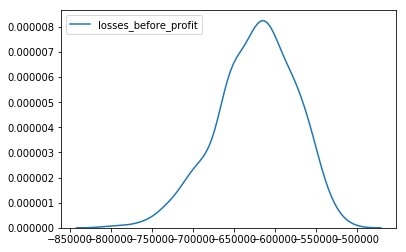

In [27]:
sns.kdeplot(final_df['losses_before_profit'])
print("Min:", round(final_df['losses_before_profit'].max() / 1000), "hundred thousand dollars")
print("Max:", round(final_df['losses_before_profit'].min() / 1000), "hundred thousand dollars")

Min: 2.12 million dollars
Max: 11.51 million dollars
Mean: 5.57 million dollars


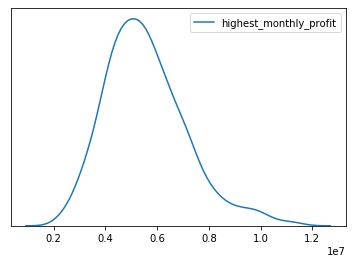

In [46]:
profit_plot = sns.kdeplot(final_df['highest_monthly_profit'])
profit_plot.set(yticklabels=[])
profit_plot.set(ylabel=None)
profit_plot.tick_params(axis='y', length=0)


print("Min:", round(final_df['highest_monthly_profit'].min() / 1000000, 2), "million dollars")
print("Max:", round(final_df['highest_monthly_profit'].max()/ 1000000, 2), "million dollars")
print("Mean:", round(final_df['highest_monthly_profit'].mean()/ 1000000, 2), "million dollars")

Min: 196.0 million dollars
Max: 1845.0 million dollars
Mean: 692.0 million dollars


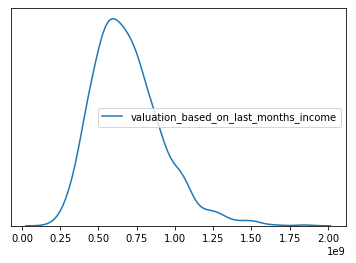

In [47]:
value_plot = sns.kdeplot(final_df['valuation_based_on_last_months_income'])
value_plot.set(yticklabels=[])
value_plot.set(ylabel=None)
value_plot.tick_params(axis='y', length=0)


print("Min:", round(final_df['valuation_based_on_last_months_income'].min() / 1000000), "million dollars")
print("Max:", round(final_df['valuation_based_on_last_months_income'].max() / 1000000), "million dollars")
print("Mean:", round(final_df['valuation_based_on_last_months_income'].mean() / 1000000), "million dollars")

Avg units: 1.09 %
Avg dollars: 6.71 %


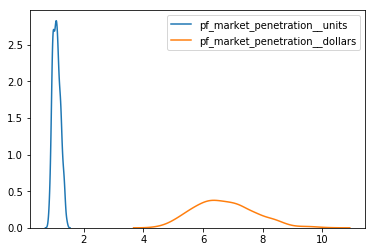

In [59]:
sns.kdeplot(final_df['pf_market_penetration__units'])
sns.kdeplot(final_df['pf_market_penetration__dollars'])
print("Avg units:", round(final_df['pf_market_penetration__units'].mean(), 2), "%")
print("Avg dollars:", round(final_df['pf_market_penetration__dollars'].mean(), 2), "%")

In [50]:
# Calculate the expected return, given different changes of failure
CHANCE_OF_BANKRUPTCY = .33
CHANCE_OF_BREAK_EVEN = .33
chance_of_success = 1 - CHANCE_OF_BANKRUPTCY - CHANCE_OF_BREAK_EVEN

AMOUNT_RAISED = 1.2 * 10 ** 6
EQUITY_SOLD = .15

# THINK THROUGH the different ways to do this. Mean vs median are both probably better
value_at_success = sum([final_df['valuation_based_on_last_months_income'].quantile(val / 10) for val in range(11)]) / 11
value_at_success2 = final_df['valuation_based_on_last_months_income'].median()
value_at_success3 = final_df['valuation_based_on_last_months_income'].mean()
print("Deciles:", round(value_at_success / 1000000))
print("Median:", round(value_at_success2 / 1000000))
print("Mean:", round(value_at_success3 / 1000000))

print()
expected_return = -1 * CHANCE_OF_BANKRUPTCY + 0 * CHANCE_OF_BREAK_EVEN + chance_of_success * value_at_success
print("Risk-adjusted value of company:", round(expected_return / 1000000), "million dollars")

print("Return as a multiple:", round(expected_return * EQUITY_SOLD / AMOUNT_RAISED))

interest_value = (expected_return - AMOUNT_RAISED)
interest_return = interest_value / ((MONTHS_ESTIMATED / 12) * AMOUNT_RAISED)
print("Return as an interest rate:", round(interest_return))

Deciles: 742
Median: 662
Mean: 692.0

Risk-adjusted value of company: 252 million dollars
Return as a multiple: 32
Return as an interest rate: 42


In [51]:
print(final_df['cost_of_funds__portion_of_loss'].mean())
print(final_df['cost_to_service_loans__portion_of_loss'].mean())
print(final_df['employee_cost__portion_of_loss'].mean())
print(final_df['first_profitable_month'].mean())

0.07577199999999999
0.094176
0.519928
13.124


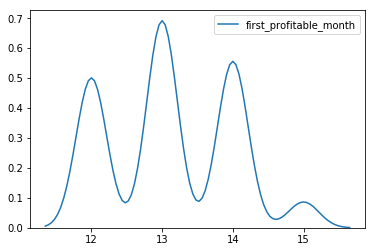

In [55]:
sns.kdeplot(final_df['first_profitable_month'])